## Loading data and initializing parameters

In [4]:
import random
from utilities import display_single_level_statistics
from simulation.simulation_parameters import SimulationParameters
from simulation.simulation_statistics import SimulationStatistics
from simulation.simulation_runner import SimulationRunner
from policies.ftrl_policy import FTRLPolicy
from policies.lfu_policy import LFUPolicy
from policies.lru_policy import LRUPolicy
from policies.policy import Policy
from typing import List
from data.path import DataPath
from data.loaders import load_movielens
from utilities import display_multi_level_statistics
from factories.cache_factory import get_bipartite_systems_from_datasets
from data.loaders import load_bipartite_movielens


random.seed(42)

## Defining single cache simulations

In [5]:
def run_single_cache_simulation():
    dataset = load_movielens(DataPath.MOVIE_LENS)
    cache_size = 50
    policies: List[Policy] = [
        LRUPolicy(cache_size),
        LFUPolicy(cache_size),
        FTRLPolicy(cache_size, dataset.catalog_size, dataset.trace.size),
    ]

    runner = SimulationRunner(threads=len(policies))
    parameters = SimulationParameters(dataset.trace, policies)
    statistics: List[SimulationStatistics] = runner.run_simulations(parameters)
    display_single_level_statistics(statistics)

## Define bipartite simulation

In [6]:
def run_multi_cache_simulation():
    datasets = load_bipartite_movielens(DataPath.MOVIE_LENS)
    cache_size = 50
    d_regular_degree = 2
    cache_count = 6
    systems = get_bipartite_systems_from_datasets(datasets, cache_size, d_regular_degree, cache_count)
    runner = SimulationRunner(threads=min([len(systems), 10]))
    statistics = runner.run_bipartite_simulations(systems, datasets)
    display_multi_level_statistics(statistics)

## Run simulation

=================== LFU ===================
System-wide cost: 5578561
Hit Ratio Per Cache
Main Storage, Level 0: 1.0
LFU, Level 1: 0.07
LFU, Level 1: 0.06
LFU, Level 1: 0.06
LFU, Level 1: 0.06
LFU, Level 1: 0.07
LFU, Level 1: 0.06
=================== LRU ===================
System-wide cost: 5592008
Hit Ratio Per Cache
Main Storage, Level 0: 1.0
LRU, Level 1: 0.06
LRU, Level 1: 0.07
LRU, Level 1: 0.07
LRU, Level 1: 0.06
LRU, Level 1: 0.07
LRU, Level 1: 0.06
=================== FTRL ===================
System-wide cost: 5289609
Hit Ratio Per Cache
Main Storage, Level 0: 1.0
FTRL, Level 1: 0.1
FTRL, Level 1: 0.09
FTRL, Level 1: 0.09
FTRL, Level 1: 0.09
FTRL, Level 1: 0.1
FTRL, Level 1: 0.09


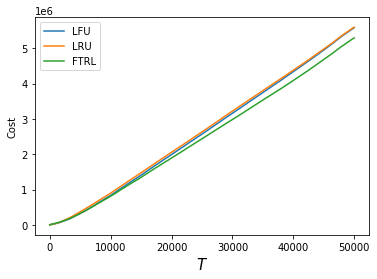

In [7]:
is_bipartite_simulation = True
if is_bipartite_simulation:
    run_multi_cache_simulation()
else:
    run_single_cache_simulation()